Initial observation: [-0.19427428  0.98094726  0.21169406]
Episode ended at step 199

Results:
Total steps: 200
Total reward: -374.137
Average reward per step: -1.871
Action range: [-5.097, 3.034]


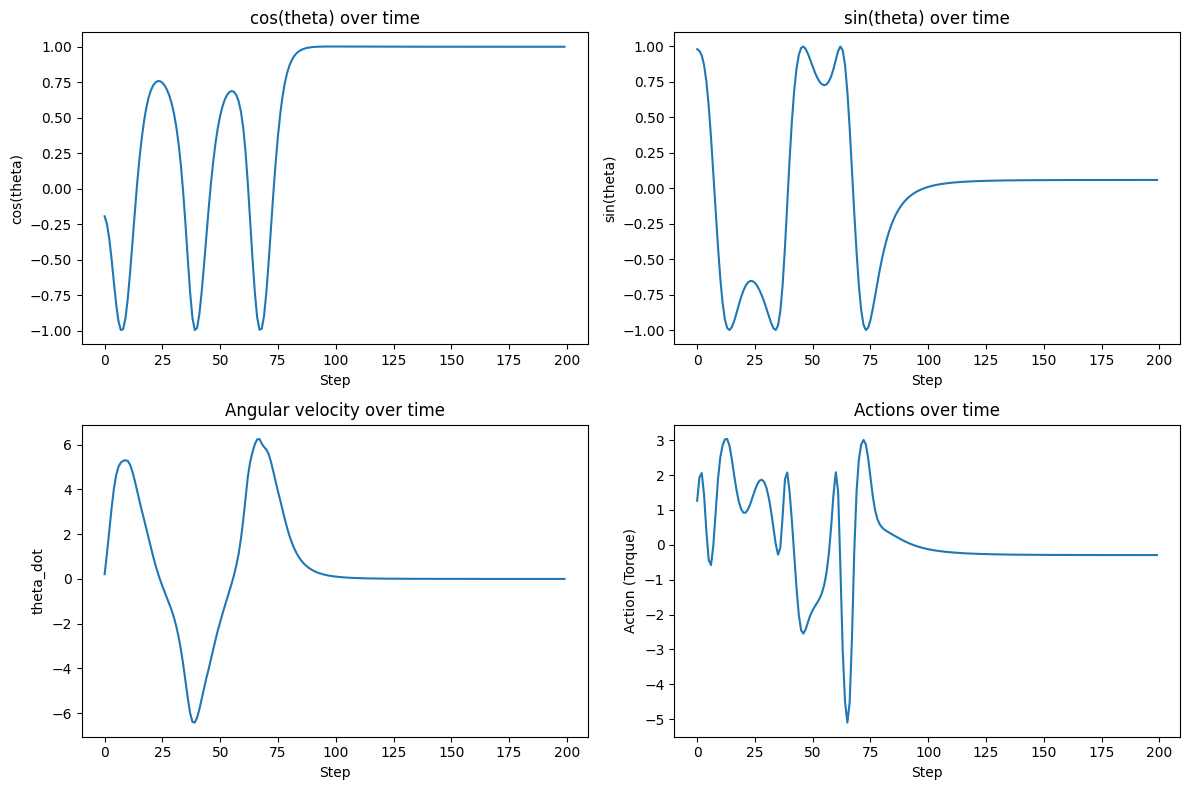

In [14]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error

# user_input = "- (0.438 * x * x1) + (0.078 * x1 * x2) + (0.031 * x2^2) - (0.375 * x^2 * x1) + (0.625 * x * x1 * x2) + (0.156 * x * x2^2) + (1.125 * x1^3) + (1.062 * x1^2 * x2) - (0.156 * x1 * x2^2) - (0.047 * x2^3) - (0.031 * x^4) - (3.000 * x^3 * x1) - (1.125 * x^3 * x2) + (0.047 * x^2 * x1^2) + (0.750 * x^2 * x1 * x2) + (0.188 * x^2 * x2^2) + (0.062 * x * x1^2 * x2) - (0.125 * x * x1 * x2^2) - (0.047 * x * x2^3) - (0.031 * x1^4) + (0.094 * x^5) - (2.250 * x^4 * x1) - (0.188 * x^4 * x2) - (0.625 * x^3 * x1^2) + (0.141 * x^3 * x1 * x2) + (0.062 * x^3 * x2^2) - (0.078 * x^2 * x1 * x2^2) - (0.031 * x^2 * x2^3) + (0.500 * x * x1^4) + (0.016 * x * x1 * x2^3) + (0.016 * x1^5) + (0.031 * x1^4 * x2)"
# user_input = "- (0.438 * a * b) + (0.078 * b * c) + (0.031 * c^2) - (0.375 * a^2 * b) + (0.625 * a * b * c) + (0.156 * a * c^2) + (1.125 * b^3) + (1.062 * b^2 * c) - (0.156 * b * c^2) - (0.047 * c^3) - (0.031 * a^4) - (3.000 * a^3 * b) - (1.125 * a^3 * c) + (0.047 * a^2 * b^2) + (0.750 * a^2 * b * c) + (0.188 * a^2 * c^2) + (0.062 * a * b^2 * c) - (0.125 * a * b * c^2) - (0.047 * a * c^3) - (0.031 * b^4) + (0.094 * a^5) - (2.250 * a^4 * b) - (0.188 * a^4 * c) - (0.625 * a^3 * b^2) + (0.141 * a^3 * b * c) + (0.062 * a^3 * c^2) - (0.078 * a^2 * b * c^2) - (0.031 * a^2 * c^3) + (0.500 * a * b^4) + (0.016 * a * b * c^3) + (0.016 * b^5) + (0.031 * b^4 * c)"

# Factorised
user_input = "c^2.0 * (-(0.047 * c) + 0.031 - 0.156 * b + a * (0.156 - 0.047 * c + a * (0.188 + 0.062 * a - 0.031 * c))) + a^3.0 * (-(1.125 * c) + a * (-0.031 + 0.094 * a - 0.188 * c)) + b * (0.078 * c + (-0.438 + 0.5 * b^3.0 + a * (-0.375 + 0.047 * b + a * (-3.0 - 2.25 * a - 0.625 * b + 0.141 * c) + c * (0.75 - 0.078 * c)) + c * (0.625 + 0.062 * b + c * (-0.125 + 0.016 * c))) * a + b * (1.062 * c + (1.125 + b * (-0.031 + 0.016 * b + 0.031 * c)) * b))"

def create_policy_function(equation_str):
    def policy_fn(obs, model=None):

        # Extract state variables from observation
        # For Pendulum-v1: obs = [cos(theta), sin(theta), theta_dot]
        a = obs[0]  # cos(theta)
        b = obs[1]  # sin(theta) 
        c = obs[2]  # theta_dot
        
        equation = equation_str.replace('^', '**')
        # Create a namespace dictionary with the state variables
        namespace = {'a': a, 'b': b, 'c': c}
        
        # Evaluate the equation with current state values
        action = eval(equation, {"__builtins__": {}}, namespace)
        
        # Ensure action is a scalar and within reasonable bounds
        if type(action) == np.ndarray:
            action = action.item()
        
        # Clip action to reasonable range
        action = np.clip(action, -16.0, 16.0)
        
        return action
            
      
    return policy_fn

def run_policy(env_id, policy_fn, model=None, max_steps=500, dt=0.001, render=False):
    env = gym.make(env_id, render_mode="human" if render else None)
    obs, _ = env.reset(seed=21)
    print("Initial observation:", obs)
    
    obs_list, action_list = [], []
    total_reward = 0

    for step in range(max_steps):
        # Gets the action from policy function
        action = policy_fn(obs, model)
        
        # Handle different action space types
        if type(env.action_space) == gym.spaces.Discrete:
            action_env = int(np.round(np.clip(action, 0, env.action_space.n - 1)))
        else:
            # For continuous action spaces (like Pendulum)
            action_env = np.array([action], dtype=np.float32)
            action_env = np.clip(action_env, env.action_space.low, env.action_space.high)

        obs_list.append(obs.copy())
        action_list.append(action)

        obs, reward, terminated, truncated, _ = env.step(action_env)
        total_reward += reward

        if render:
            time.sleep(dt)
            
        if terminated or truncated:
            print(f"Episode ended at step {step}")
            break

    env.close()
    return np.array(obs_list), np.array(action_list), total_reward

# Create the policy function from the user input
policy_function = create_policy_function(user_input)



    
# Run the policy
observations, actions, total_reward = run_policy(
    env_id="Pendulum-v1",
    policy_fn=policy_function,
    model=None,
    max_steps=500,
    dt=0.05,  
    render=True )

print(f"\nResults:")
print(f"Total steps: {len(observations)}")
print(f"Total reward: {total_reward:.3f}")
print(f"Average reward per step: {total_reward/len(observations):.3f}")
print(f"Action range: [{actions.min():.3f}, {actions.max():.3f}]")

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(observations[:, 0])
plt.title('cos(theta) over time')
plt.xlabel('Step')
plt.ylabel('cos(theta)')

plt.subplot(2, 2, 2)
plt.plot(observations[:, 1])
plt.title('sin(theta) over time')
plt.xlabel('Step')
plt.ylabel('sin(theta)')

plt.subplot(2, 2, 3)
plt.plot(observations[:, 2])
plt.title('Angular velocity over time')
plt.xlabel('Step')
plt.ylabel('theta_dot')

plt.subplot(2, 2, 4)
plt.plot(actions)
plt.title('Actions over time')
plt.xlabel('Step')
plt.ylabel('Action (Torque)')

plt.tight_layout()
plt.show()